In [1]:
import numpy as np
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
#import Functions as fu
import line_profiler
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import time
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion
import seaborn as sns
from dateutil.relativedelta import relativedelta
#import ScorecardFunctions as SCF
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

In [2]:
import torch
import sigkernel

# Specify the static kernel (for linear kernel use sigkernel.LinearKernel())
static_kernel = sigkernel.Linear_ID_Kernel()

# Specify dyadic order for PDE solver (int > 0, default 0, the higher the more accurate but slower)
dyadic_order = 2

# Specify maximum batch size of computation; if memory is a concern try reducing max_batch, default=100
max_batch = 100

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# Synthetic data
batch, len_x, len_y, dim = 5, 10, 20, 2
X = torch.rand((batch,len_x,dim), dtype=torch.float64, device='cuda') # shape (batch,len_x,dim)
Y = torch.rand((batch,len_y,dim), dtype=torch.float64, device='cuda') # shape (batch,len_y,dim)
Z = torch.rand((batch,len_x,dim), dtype=torch.float64, device='cuda') # shape (batch,len_y,dim)

test = signature_kernel.compute_expected_scoring_rule(X,Y)
print(test)
print(test.backward)



# class _SigKernel(torch.autograd.Function):
#     """Signature kernel k_sig(x,y) = <S(f(x)),S(f(y))> where k(x,y) = <f(x),f(y)> is a given static kernel"""

#     @staticmethod
#     def forward(ctx, X, Y, static_kernel, dyadic_order, _naive_solver=False):



c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


tensor(-1.0591, device='cuda:0', dtype=torch.float64)
<bound method Tensor.backward of tensor(-1.0591, device='cuda:0', dtype=torch.float64)>


In [4]:
#Observations
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observations = xr.open_zarr(obs_path)

forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2



<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [5]:
def timecutting(obsxarray,forsxarray, days, predtimedelta):
    startdate = datetime(2020,1,1)
    newdate = startdate + timedelta(days=days)
    obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)
    
    return obsxarray['geopotential'].sel(level = 500, time = slice(startdate, obsnewdate)), forsxarray['geopotential'].sel(level = 500, time = slice(startdate, newdate)),

def scalebyobsadjusted(observations,forecasts,shapeparam):
    mean = np.mean(observations)
    std = np.std(observations)
    scaledobs = (observations - mean)/(std*np.sqrt(shapeparam))
    scaledfors = (forecasts - mean)/(std*np.sqrt(shapeparam))

    return scaledobs, scaledfors 


In [35]:

weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

weights = torch.tensor([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437], dtype=torch.double, requires_grad=True)

def pkfulladjusted(observations,forecasts,zero):

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        lead = forecasts.shape[1]
        latlength = forecasts.shape[3]

        if latlength == 32:
             #print("32")
             usedweights = weights
        # if latlength == 121:
        #      #print("121")
        #      usedweights = weightslarger


        #print(time,lead)
        
        pkarray = torch.zeros((latlength, time, lead, 3), dtype=torch.double, requires_grad=True)
        pkarray = pkarray.clone()

        #print(pkarray.shape)

        for lat in range(latlength):
            #print(lat)

        #Across all t, across all lags
            for t in range(time):
                #print(t)
                for lag in range(2,lead+1):
                    #print(lag)
                    fors = forecasts[t,0:lag,:,lat]
                    #shape lag,64 Length lag, dimension 64
                    obs = observations[2*t+zero:2*t+zero+lag,:,lat]

                    fors = np.expand_dims(fors, axis = 0) #1,lag,64
                    obs = np.expand_dims(obs, axis = 0) #1,64


                    llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                    llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                    X = torch.tensor(llfors, dtype=torch.double)
                    y = torch.tensor(llobs, dtype=torch.double)


                    K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                    K_XX = signature_kernel.compute_Gram(X, X, sym=False, max_batch=100)
                    K_yy = signature_kernel.compute_Gram(y, y, sym=False, max_batch=100)

                    #print(K_XX)

                    pkarray[lat,t,lag-1,0] = K_Xy
                    pkarray[lat,t,lag-1,1] = K_XX
                    pkarray[lat,t,lag-1,2] = K_yy

        pktorchlat = torch.sum(pkarray[:,:,:,:]*weights[:,None,None,None], dim =0).shape
        #.mean(torch.sum(pkarray[:,:,:,:]*weights[:,None,None,None], dim =0),dim=0).shape

        pktimetorch = torch.mean(torch.sum(pkarray[:,:,:,:]*weights[:,None,None,None], dim =0),dim=0)
        distancetorch = pktimetorch[:,1]+pktimetorch[:,2]-2*pktimetorch[:,0]
        scoretorch = pktimetorch[:,1]-2*pktimetorch[:,0]
        # #
        # pkarraylat = np.sum(pkarray*usedweights[:,None,None,None],axis=0)
        # pktime = np.mean(pkarraylat, axis=0)
        # distance = pktime[:,1]+pktime[:,2]-2*pktime[:,0]
        # score = pktime[:,1] - 2*pktime[:,0]

    
        return(pkarray,pktimetorch, distancetorch,scoretorch)

In [29]:
newobs, newfors = timecutting(observations,forecast2,5,30)

In [7]:
ob, fo = timecutting(observations,forecast2,3,10) # 3 days 10 lead
ob = ob.values
fo = fo[:,0:30,:,:].values
ob, fo = scalebyobsadjusted(ob,fo,fo.shape[2])


In [36]:
pkarray,pktimetorch, distancetorch, scoretorch= pkfulladjusted(ob,fo,0)

        # # pkarraylat = np.sum(pkarray*usedweights[:,None,None,None],axis=0)
        # # pktime = np.mean(pkarraylat, axis=0)
        # # distance = pktime[:,1]+pktime[:,2]-2*pktime[:,0]
        # # score = pktime[:,1] - 2*pktime[:,0]

    
        # return(pkarray)

        # distance = pktime[:,1]+pktime[:,2]-2*pktime[:,0]
        # score = pktime[:,1] - 2*pktime[:,0]

In [ ]:
def pkfulladjusted(observations,forecasts,zero):
        #observations are l,d 
        #forecasts are b,l,d

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

        length = forecasts.shape[1]
        batch = forecasts.shape[0]
        time = forecasts.shape[0]

        X = forecasts
        y = observations

        sigkernel.transform(X, scale = 1, at=True,11=False)



        X = torch.tensor(sigkernel.transform(forecasts[t,:,0:lag,:,lat], scale = 1, at = True, ll = False), dtype=torch.double)
                #print(X.shape)
        y = torch.tensor(sigkernel.transform(np.expand_dims(observations[2*t+zero:2*t+zero+lag,:,lat], axis = 0), scale = 1, at = True, ll = False), dtype=torch.double)

                score = signature_kernel.compute_scoring_rule(X,y)
                #print(score.shape)

                pkarray[lat,t,lag-1] = score

    return pkarray



        #print(time,lead)
        
        pkarray = np.zeros((latlength,time,lead,3))
        #print(pkarray.shape)

        for lat in range(latlength):
            #print(lat)

        #Across all t, across all lags
            for t in range(time):
                #print(t)
                for lag in range(2,lead+1):
                    #print(lag)
                    fors = forecasts[t,0:lag,:,lat]
                    #shape lag,64 Length lag, dimension 64
                    obs = observations[2*t+zero:2*t+zero+lag,:,lat]

                    fors = np.expand_dims(fors, axis = 0) #1,lag,64
                    obs = np.expand_dims(obs, axis = 0) #1,64


                    llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                    llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                    X = torch.tensor(llfors, dtype=torch.double)
                    y = torch.tensor(llobs, dtype=torch.double)


                    K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                    K_XX = signature_kernel.compute_Gram(X, X, sym=False, max_batch=100)
                    K_yy = signature_kernel.compute_Gram(y, y, sym=False, max_batch=100)

                    pkarray[lat,t,lag-1,0] = K_Xy
                    pkarray[lat,t,lag-1,1] = K_XX
                    pkarray[lat,t,lag-1,2] = K_yy
        
        pkarraylat = np.sum(pkarray*usedweights[:,None,None,None],axis=0)
        pktime = np.mean(pkarraylat, axis=0)
        distance = pktime[:,1]+pktime[:,2]-2*pktime[:,0]
        score = pktime[:,1] - 2*pktime[:,0]

    
        return(pkarray,pkarraylat,distance,score)

In [44]:
#have backward tensor
scoretorch.backward

<bound method Tensor.backward of tensor([  0.0000, -73.1933, -73.5005, -74.0386, -74.5472, -75.1727, -75.6514,
        -76.1767, -76.5049, -76.8672, -76.9571, -77.0715, -76.9370, -76.9056,
        -76.6587, -76.5582, -76.2462, -76.1189, -75.7635, -75.6179, -75.2269,
        -75.1056, -74.7405, -74.6402, -74.2666, -74.1884, -73.8319, -73.7919,
        -73.4558, -73.4547], dtype=torch.float64, grad_fn=<SubBackward0>)>

In [31]:
full[:,:,:,:]*weights[:,None,None,None] # == full[:,:,:,:] not true correct
print(full.shape)
torch.sum(full[:,:,:,:]*weights[:,None,None,None], dim =0).shape
torch.mean(torch.sum(full[:,:,:,:]*weights[:,None,None,None], dim =0),dim=0).shape

pktimetorch = torch.mean(torch.sum(full[:,:,:,:]*weights[:,None,None,None], dim =0),dim=0)

torch.Size([32, 7, 30, 3])


In [34]:
distancetorch = pktimetorch[:,1]+pktimetorch[:,2]-2*pktimetorch[:,0]
distancetorch

tensor([0.0000e+00, 2.9445e-03, 5.6062e-03, 6.9613e-03, 1.1093e-02, 1.3465e-02,
        2.0436e-02, 2.7241e-02, 3.8111e-02, 5.0186e-02, 1.1315e-01, 2.0377e-01,
        3.7817e-01, 5.3857e-01, 8.1172e-01, 1.0351e+00, 1.3971e+00, 1.6566e+00,
        2.0631e+00, 2.2926e+00, 2.6954e+00, 2.8472e+00, 3.2123e+00, 3.3127e+00,
        3.6863e+00, 3.7645e+00, 4.1210e+00, 4.1609e+00, 4.4970e+00, 4.4982e+00],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [37]:
distancetorch.backward

<bound method Tensor.backward of tensor([0.0000e+00, 2.9445e-03, 5.6062e-03, 6.9613e-03, 1.1093e-02, 1.3465e-02,
        2.0436e-02, 2.7241e-02, 3.8111e-02, 5.0186e-02, 1.1315e-01, 2.0377e-01,
        3.7817e-01, 5.3857e-01, 8.1172e-01, 1.0351e+00, 1.3971e+00, 1.6566e+00,
        2.0631e+00, 2.2926e+00, 2.6954e+00, 2.8472e+00, 3.2123e+00, 3.3127e+00,
        3.6863e+00, 3.7645e+00, 4.1210e+00, 4.1609e+00, 4.4970e+00, 4.4982e+00],
       dtype=torch.float64, grad_fn=<SubBackward0>)>

(2, 7)


<Axes: >

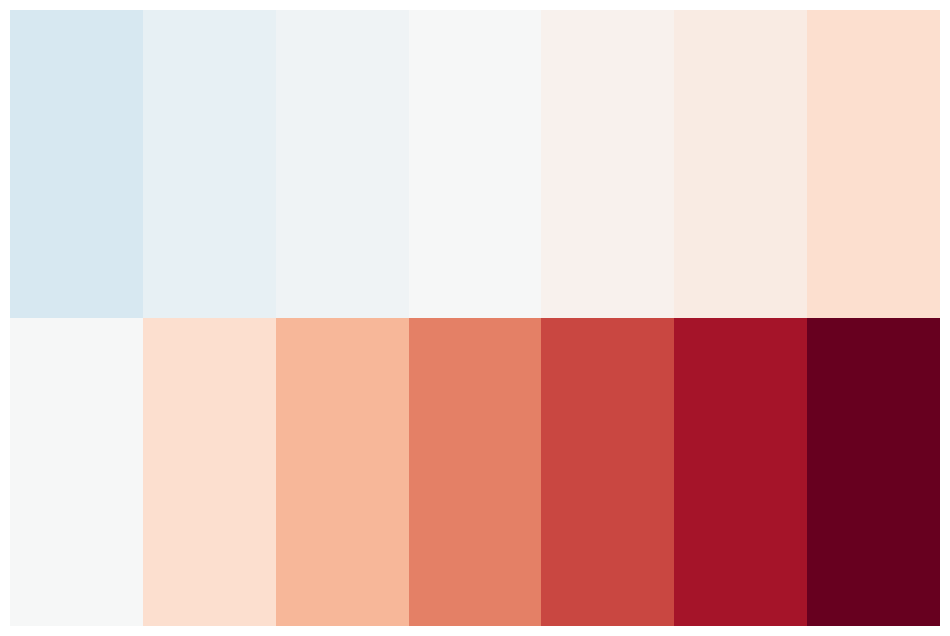

In [ ]:
data = np.asarray([[-1,-0.5,-0.25,0,0.25,0.5,1],[0,1,2,3,4,5,6]])

print(data.shape)
fig = plt.figure(figsize=(12, 8))  # Increased figure height to accommodate 6 rows
spec = gridspec.GridSpec(
    nrows=1,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=1, 
    figure=fig, 
)
#positive darker red
#negative darker blue 
sns.heatmap(
            data,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
        )